# Continuando os testes para aperfeiçoamento do modelo de regressão

- Nesse caso o nosso objetivo é realizar o tratamento da escala dos dados, separando em **preprocessamento** apenas para as *categóricas*, **preprocessamento simples** onde nós utilizaremos o **RobustScaler** em todas as colunas, com exceção das categóricas e a Target, e um **preprocessamento completo** onde faremos tratamentos específicos para as colunas tornando o *Pipeline* mais complexo.

In [1]:
# Importação das bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)

from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor
)

sns.set_theme(palette='bright')


In [2]:
# Importando os dados tratados
df = pd.read_parquet(DADOS_LIMPOS)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
# Pegando as colunas que vão sofrer transformações
col_target = ['median_house_value']
col_onehot = ['ocean_proximity']
col_ordinal = ['median_income_cat']

In [5]:
# Separando as colunas que vão ser usadas no RobustScaler
col_robust = df.columns.difference(col_target + col_onehot + col_ordinal)
col_robust

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
# Colunas do StandardScaler
col_standard = ['latitude', 'longitude', 'housing_median_age']

# Colunas do PowerTransformer
col_power = df.columns.difference(
    col_target + col_onehot + col_ordinal + col_standard
)
col_power

Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object')

In [7]:
preprocessamento_cat = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), col_onehot),
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), col_ordinal),
    ],
    remainder='passthrough'
)

preprocessamento_simples = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), col_onehot),
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), col_ordinal),
        ('robust_scaler', RobustScaler(), col_robust),
    ],
)

preprocessamento_completo = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), col_onehot),
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), col_ordinal),
        ('standard_scaler', StandardScaler(), col_standard),
        ('power_transformer', PowerTransformer(), col_power)
    ],
)

In [8]:
# Separando em X e y
X = df.drop(columns=col_target)
y = df[col_target]

In [9]:
# Grade de parâmetros dos transformadores
param_grid = {
    "regressor__preprocessor": [preprocessamento_cat, preprocessamento_simples, preprocessamento_completo],
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}

# Função que constrói Pipeline com preprocessamento e regressor e executa o GridSearchCV
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento_completo,
    target_transformer=PowerTransformer(),
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('standard_scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['latitude',
                                                                                                               'longitud...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [10]:
# Submetendo os dados ao modelo
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('standard_scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['latitude',
                                                                                                               'longitud...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
# O melhor parâmetro
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('one_hot', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('robust_scaler', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'rooms_per_household', 'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [12]:
# A melhor pontuação
grid_search.best_score_

np.float64(-54413.820940186946)

In [13]:
# Criando um DF com as colunas e seus respectivos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
robust_scaler__latitude,-1.080541
robust_scaler__longitude,-1.067795
one_hot__ocean_proximity_INLAND,-0.450667
robust_scaler__population_per_household,-0.234484
one_hot__ocean_proximity_NEAR BAY,-0.202083
robust_scaler__total_rooms,-0.096980
robust_scaler__total_bedrooms,-0.081842
one_hot__ocean_proximity_NEAR OCEAN,-0.057395
robust_scaler__population,-0.034641
ordinal_encoder__median_income_cat,0.033297


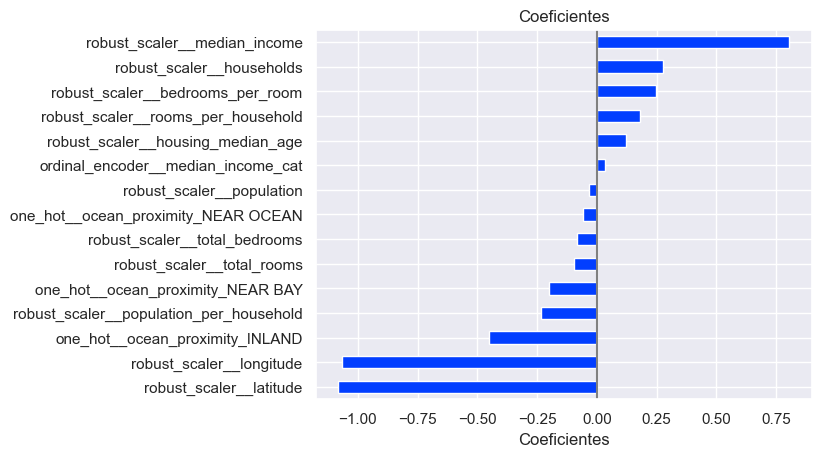

In [14]:
plot_coeficientes(coefs)

- Com o tratamento de escala nós já tivemos mudanças significativas nos coeficientes, nesse caso não resultou em coeficientes zeradas, como no caso anterior, e como era esperado a coluna `median_income` se destaca como sendo uma variável importante para prever o Target, assim como a **localização** com as colunas de `longitude e latitude`. Os coeficientes apresentados neste gráfico destacam a relevância das variáveis no modelo preditivo. A renda e a localização mostraram-se fatores determinantes no preço dos imóveis, indicando como aspectos econômicos e geográficos influenciam diretamente o mercado imobiliário. Valores absolutos mais altos nos coeficientes refletem maior impacto dessas variáveis na previsão.

In [15]:
# Recriando o dicionário de regressores para a nova análise
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinearRegression_cat': {
        'preprocessor': preprocessamento_cat,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
    'LinearRegression_grid_search': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

In [16]:
# Treinando e validando os modelos do dicionário de regressores. Transformando os resultados em um DF.
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **modelo_etapas)
    for nome_modelo, modelo_etapas in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.008383,0.009,-0.000081,-77516.042766,-96239.705692,0.017383
1,DummyRegressor,0.009727,0.011396,-0.000146,-75787.787194,-95217.629397,0.021123
2,DummyRegressor,0.0,0.017379,-0.001737,-76753.598961,-96253.253947,0.017379
3,DummyRegressor,0.00601,0.008707,-0.000101,-76837.804811,-95983.885799,0.014717
4,DummyRegressor,0.005527,0.008004,-0.000114,-76617.245449,-96182.764729,0.01353
5,LinearRegression_cat,0.047693,0.025398,0.682162,-39855.690921,-54254.958115,0.07309
6,LinearRegression_cat,0.036154,0.027217,0.66999,-40272.565406,-54695.230224,0.063371
7,LinearRegression_cat,0.050987,0.017881,0.649247,-42178.059246,-56955.988686,0.068867
8,LinearRegression_cat,0.033312,0.015967,0.669873,-40806.492452,-55146.31876,0.049278
9,LinearRegression_cat,0.063127,0.015694,0.669023,-40788.496555,-55331.351171,0.078822


In [17]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.005929,0.010897,-0.000436,-76702.495836,-95975.447913,0.016826
LinearRegression_cat,0.046254,0.020431,0.668059,-40780.260916,-55276.769391,0.066686
LinearRegression_grid_search,0.089216,0.021016,0.677954,-38671.835849,-54442.866293,0.110232


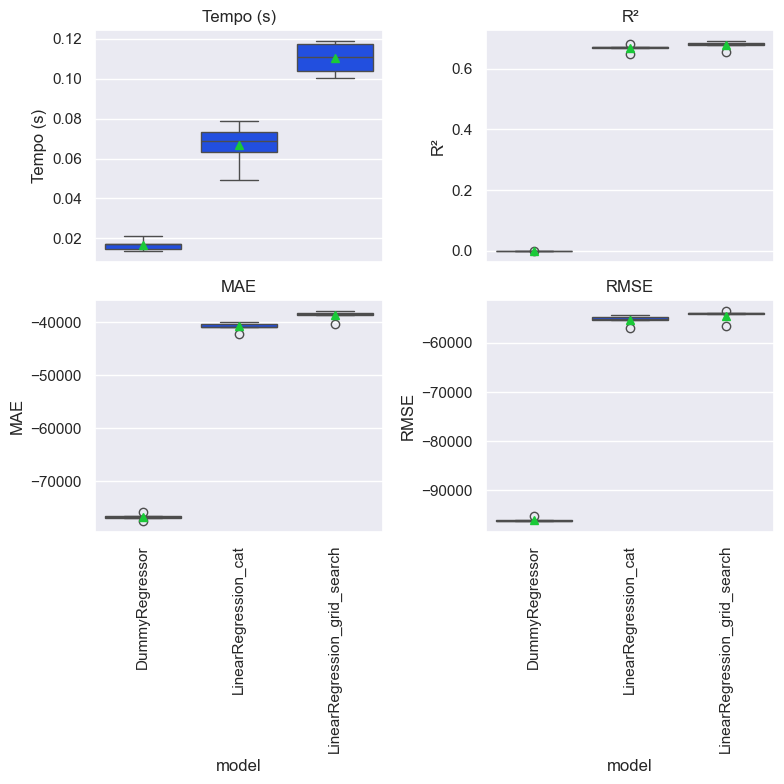

In [18]:
plot_comparar_metricas_modelos(df_resultados)

- Como é esperado o modelo com maior complexidade acabou sendo aquele que mais demorou a executar, mas ao mesmo tempo com o tratamento da escala tivemos uma pequena melhora nas métricas, vale a pena continuar investigando!

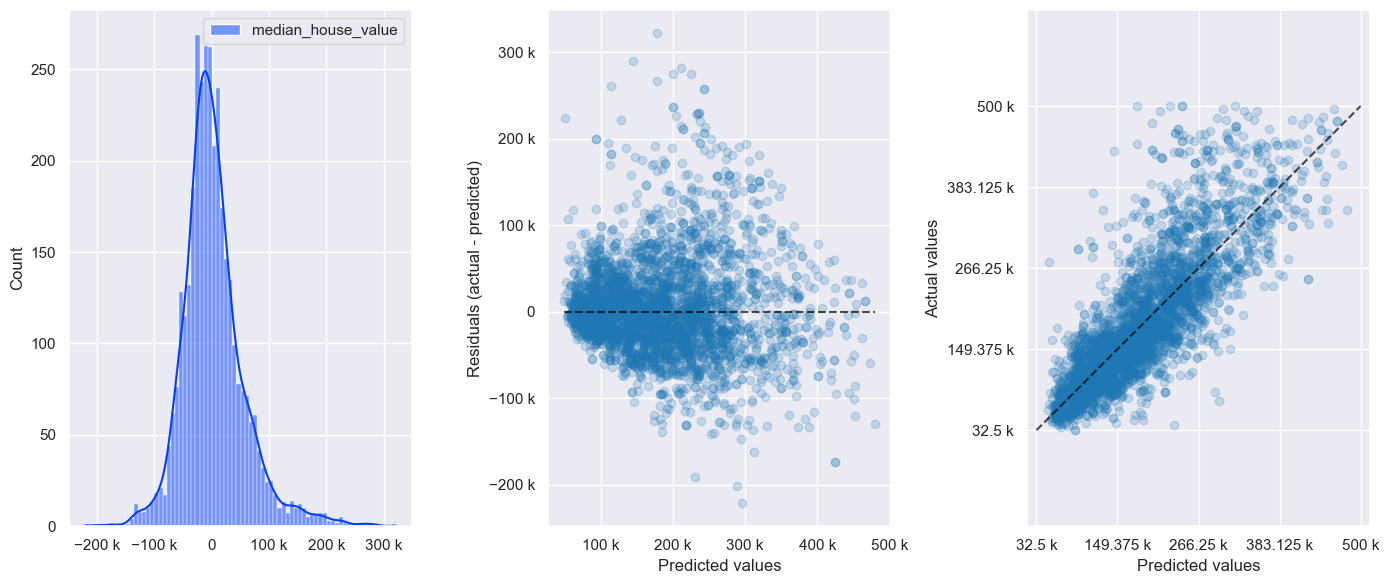

In [19]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.20, eng_formatter=True)

- O modelo continua errando para preços de casas entre 150.000 e 500.000, ou seja, para casa mais caras.

### Conclusão
- Aprendemos até aqui que um preprocessamento simples, que é o tratamento das categóricas e um único transformador para demais colunas(RobustScaler) foi suficiente para que possamos continuar nos aprofundando na criação do nosso modelo final.